<a href="https://colab.research.google.com/github/AbeRodz/computer-vision-II/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [53]:
!nvidia-smi

Sun Jul 30 17:34:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |    239MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
import cv2 as cv
import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from concurrent.futures import ThreadPoolExecutor

In [8]:
torch.cuda.get_device_capability()

(7, 5)

In [10]:
# Check available GPU memory and total GPU memory
total_free_gpu_memory, total_gpu_memory = torch.cuda.mem_get_info()
print(f"Total free GPU memory: {round(total_free_gpu_memory * 1e-9, 3)} GB")
print(f"Total GPU memory: {round(total_gpu_memory * 1e-9, 3)} GB")

Total free GPU memory: 15.727 GB
Total GPU memory: 15.835 GB


In [11]:
# Set batch size depending on amount of GPU memory
total_free_gpu_memory_gb = round(total_free_gpu_memory * 1e-9, 3)
if total_free_gpu_memory_gb >= 16:
  BATCH_SIZE = 128 # Note: you could experiment with higher values here if you like.
  IMAGE_SIZE = 224
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")
else:
  BATCH_SIZE = 32
  IMAGE_SIZE = 128
  print(f"GPU memory available is {total_free_gpu_memory_gb} GB, using batch size of {BATCH_SIZE} and image size {IMAGE_SIZE}")

GPU memory available is 15.727 GB, using batch size of 32 and image size 128


In [13]:
torch.backends.cudnn.benchmark = True

In [14]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [15]:
cd /content/drive/MyDrive/dataset/vision/kitti

/content/drive/MyDrive/dataset/vision/kitti


In [16]:
ls

best_model_state.bin  testing/  training/  transfer_learning_vgg/


In [17]:
# Load directories
train_data_dir = "./training/image_2/"
train_gt_dir = "./training/gt_image_2/"

test_data_dir = "./testing/"

In [18]:
train_data_dir

'./training/image_2/'

In [19]:
TRAINSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.8)
print(f"Number of Training Examples: {TRAINSET_SIZE}")

VALIDSET_SIZE = int(len(os.listdir(train_data_dir)) * 0.1)
print(f"Number of Validation Examples: {VALIDSET_SIZE}")

TESTSET_SIZE = int(len(os.listdir(train_data_dir)) - TRAINSET_SIZE - VALIDSET_SIZE)
print(f"Number of Testing Examples: {TESTSET_SIZE}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [20]:
def open_images(path, masked = False):
  temp = []
  def read_image(image):

    return Image.open(os.path.join(path,image)).resize((128, 128))

  images = os.listdir(path)
  images=sorted(images)
  if masked==True:
    images = [entry for entry in images if "road" in entry]

  with ThreadPoolExecutor() as executor:
    files = executor.map(read_image,images)
    for f in files:
      temp.append(np.asarray(f))
  return np.array(temp)

In [21]:
data=open_images(train_data_dir,masked=False)

In [22]:
data.shape

(289, 128, 128, 3)

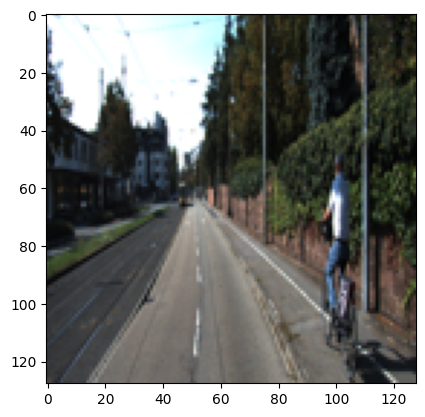

In [23]:
plt.imshow(data[0])

In [24]:
true_mask=open_images(train_gt_dir,masked=True)

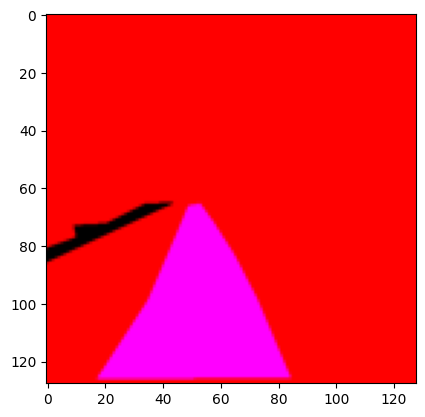

In [25]:
plt.imshow(true_mask[0])

In [26]:
def convert_to_binary_mask(true_mask):
    noMasks=len(true_mask)
    for i in range(noMasks):
        #convert all masks to just binary masks (road and no road)
        road_label =np.array([255, 0, 255])
        cond=np.all(true_mask[i] == road_label, axis = 2)
        true_mask[i]=true_mask[i] * cond[..., np.newaxis]

In [27]:
convert_to_binary_mask(true_mask)

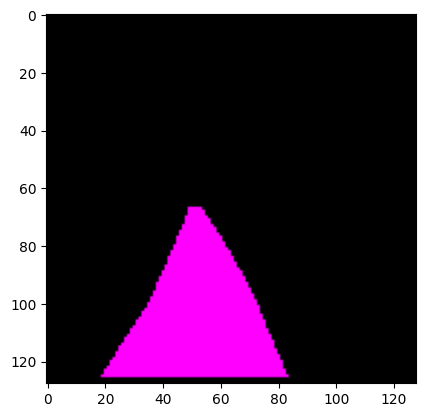

In [28]:
plt.imshow(true_mask[0])

In [29]:
true_mask=np.dot(true_mask[..., :3], [0.2989, 0.5870, 0.1140])
true_mask=np.expand_dims(true_mask, axis=-1)

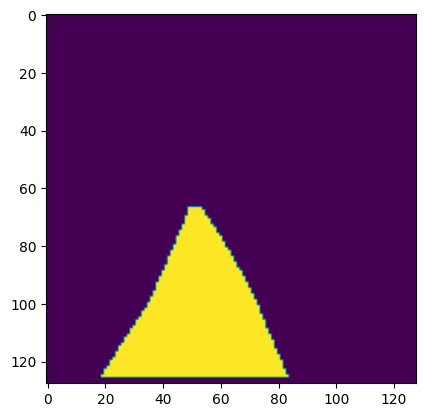

In [30]:
plt.imshow(true_mask[0])

In [31]:
true_mask[true_mask != 0.0]=1.0

In [32]:
data  = data / 255.0

In [33]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5,border_mode=cv.BORDER_CONSTANT),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RGBShift(r_shift_limit=1, g_shift_limit=1, b_shift_limit=1, p=0.5),

])

In [34]:
data=data.astype(np.float32)
true_mask=true_mask.astype(np.float32)

In [35]:
test_aug=augmentation_pipeline(image=data[5], mask=true_mask[5])
test_example=test_aug["image"]
test_mask=test_aug["mask"]

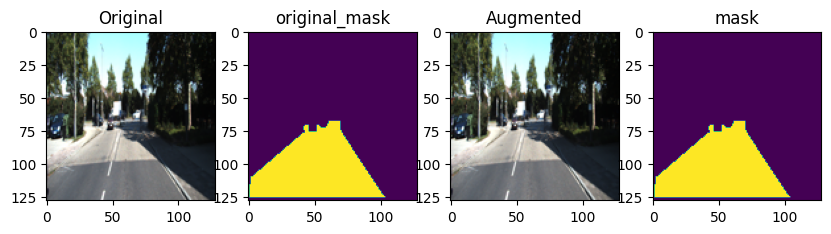

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(data[5])
ax[0].set_title("Original")

ax[1].imshow(true_mask[5])
ax[1].set_title("original_mask")


ax[2].imshow(test_example)
ax[2].set_title("Augmented")

ax[3].imshow(test_mask)
ax[3].set_title("mask")

plt.show()

In [37]:
num_augmented=3
for i in range(len(data)):
    for j in range(num_augmented):
      image = data[i]
      mask = true_mask[i]

      augmented = augmentation_pipeline(image=image, mask=mask)

      image_augmented = augmented["image"]
      mask_augmented = augmented["mask"]
      data = np.vstack((data, image_augmented[np.newaxis,...]))
      true_mask = np.vstack((true_mask, mask_augmented[np.newaxis,...]))

In [38]:
data.shape

(1156, 128, 128, 3)

In [39]:
true_mask.shape

(1156, 128, 128, 1)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, true_mask,test_size = 0.1, random_state =42, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size = 0.1, random_state =42, shuffle = True)

In [ ]:
X_train= X_train.transpose((0, 3, 1, 2))
X_test = X_test.transpose((0, 3, 1, 2))
y_train = y_train.transpose((0, 3, 1, 2))
y_test=y_test.transpose((0, 3, 1, 2))
X_val=X_val.transpose((0, 3, 1, 2))
y_val=y_val.transpose((0, 3, 1, 2))

In [ ]:
X_train.shape

In [40]:
train_set_size = int(len(data) * 0.8)
print(f"Number of Training Examples: {train_set_size}")

validation_set_size = int(len(data) * 0.1)
print(f"Number of Validation Examples: {validation_set_size}")

test_set_size = len(data) - train_set_size - validation_set_size
print(f"Number of Testing Examples: {test_set_size}")

Number of Training Examples: 924
Number of Validation Examples: 115
Number of Testing Examples: 117


In [41]:
X_test=data[:test_set_size].transpose((0, 3, 1, 2))
y_test=true_mask[:test_set_size].transpose((0, 3, 1, 2))
print(f'test set size {X_test.shape}')


#rest of the data will be agumented and shuffled for training
data=data[test_set_size:]
true_mask=true_mask[test_set_size:]

# Shuffle the indices
shuffled_indices = np.random.permutation(len(data))

# Use the shuffled indices to shuffle both arrays
shuffled_data = data[shuffled_indices]
shuffled_masks = true_mask[shuffled_indices]

test set size (117, 3, 128, 128)


In [42]:
#train_test_validation split
X_train=shuffled_data[:train_set_size].transpose((0, 3, 1, 2))
y_train=shuffled_masks[:train_set_size].transpose((0, 3, 1, 2))
print(f'training set size {X_train.shape}')

X_val=shuffled_data[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
y_val=shuffled_masks[train_set_size:train_set_size+validation_set_size].transpose((0, 3, 1, 2))
print(f'val set size {X_val.shape}')

training set size (924, 3, 128, 128)
val set size (115, 3, 128, 128)


In [43]:
#create dataset class
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
    def __init__(self, imgs,mask):
        self.imgs=imgs
        self.mask=mask

    def __len__(self):
        return len(self.imgs)

    def get_batch_imgs(self, idx):
        # Fetch a batch of inputs
        return self.imgs[idx]

    def get_batch_masks(self, idx):
    # Fetch a batch of inputs
        return self.mask[idx]


    def __getitem__(self, index):
        imgs=self.get_batch_imgs(index)
        masks=self.get_batch_masks(index)
        return imgs,masks

In [45]:
train_dataset = ImageDataset(X_train,y_train)
val_dataset = ImageDataset(X_val, y_val)
test_dataset = ImageDataset(X_test, y_test)

# Create a DataLoader from the dataset
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_dataloader=DataLoader(val_dataset, batch_size=32, shuffle=True)
# test_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=False)

train_dataloader = DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=2,pin_memory=True)
val_dataloader=DataLoader(val_dataset, batch_size=32, shuffle=True,num_workers=2,pin_memory=True)
test_dataloader=DataLoader(test_dataset, batch_size=32, shuffle=False,num_workers=2,pin_memory=True)

print(f"Train dataloader length: {len(train_dataloader)} batches of size {64}")
print(f"Validation dataloader length: {len(val_dataloader)} batches of size {64}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {64}")

Train dataloader length: 29 batches of size 64
Validation dataloader length: 4 batches of size 64
Test dataloader length: 4 batches of size 64


# Creando U-NET

In [ ]:
from torchvision.models import vgg19, VGG19_Weights

In [ ]:
weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
vgg19_model = vgg19(weights=weights)

vgg19_model.to("cuda")

torchsummary.summary(vgg19_model, input_size=(3, 128, 128))
vgg19_model.modules

In [ ]:
for param in vgg19_model.parameters():
    param.requires_grad = False

In [ ]:
def train(model, optimizer, criterion, data, epochs, ):
    train_loader = data["train"]
    valid_loader = data["valid"]

    if torch.cuda.is_available():
        model.to("cuda")
    train_loss = []
    valid_loss = []

    for epoch in range(epochs):

        model.train()
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())

            loss = criterion(output.float(), train_target.float())
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()


        epoch_train_loss = epoch_train_loss / len(train_loader)

        train_loss.append(epoch_train_loss)

        model.eval()

        epoch_valid_loss = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()


        epoch_valid_loss = epoch_valid_loss / len(valid_loader)

        valid_loss.append(epoch_valid_loss)

        print("Epoch: {}/{} - Train loss {:.6f} - Valid Loss {:.6f}".format(
        epoch+1, epochs, epoch_train_loss,  epoch_valid_loss,

        ))

    history = {}
    history["train_loss"] = train_loss
    history["valid_loss"] = valid_loss

    return history

In [46]:
class IoULoss(torch.nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        self.eps = 1e-6

    def forward(self, y_pred : torch.Tensor, y_true: torch.Tensor):
        # Flatten tensors
        y_pred = y_pred.view(-1)
        y_true = y_true.view(-1)

        intersection = (y_pred * y_true).sum()
        total = y_pred.sum() + y_true.sum()
        union = total - intersection

        # Calculate the IoU  loss
        iou = intersection / (union + self.eps)
        return 1 - iou

In [ ]:
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
loss = IoULoss().to("cuda")
#metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": train_dataloader, "valid": val_dataloader, "image_width": 128, "image_height": 128}
writer = {"train": SummaryWriter(log_dir="transfer_learning_vgg/train"),
          "valid": SummaryWriter(log_dir="transfer_learning_vgg/valid")}

history = train_epoch(vgg19_model,
                train_dataloader,
                loss,
                optimizer,
                'cuda')

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [47]:
import torchvision.transforms.functional as TF

In [48]:
#since there is alot of double Conv in this architecture it's better to create a class to write less redundant code
class DoubleConv(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv,self).__init__() # essentail to use torch.nn.Module
        #ex : for the first layer
        #in_channels would be 3 for RGB image
        #out_channels would be 64
        #bias is set to false because we apply batch norm later so it's unnecassary
        self.dconv=torch.nn.Sequential(torch.nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 torch.nn.BatchNorm2d(out_channels),
                                 torch.nn.ReLU(inplace=True),
                                 torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False),
                                 torch.nn.BatchNorm2d(out_channels),
                                 torch.nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.dconv(x)



class UNET(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET,self).__init__()

        self.ups = torch.nn.ModuleList()
        self.downs = torch.nn.ModuleList()

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(torch.nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) #this is not deconv this just upsampling
            self.ups.append(DoubleConv(feature*2, feature))



        self.left_over = DoubleConv(features[-1], features[-1]*2) #this represents the last part which starts the UP phase

        self.final_conv = torch.nn.Conv2d(features[0], out_channels, kernel_size=1) #output segmentation  map

    def forward(self,x):
        skip_connections = []

        #starting the down phase will iterate through the downs module
        for layer in self.downs:
            x=layer(x)
            skip_connections.append(x)#save this to feed it later
            x=self.pool(x)

        #to move from left to right we pass through the "left_over"

        x=self.left_over(x)
        skip_connections=skip_connections[::-1]
        for idx in range(0,len(self.ups), 2): #our goal it so feed to transposed conv and add skipped connection ups has 2 steps in each so we will make it a step of 2

            sc=skip_connections[idx//2]
            x=self.ups[idx](x) #step 1

            if x.shape != sc.shape:
                x = TF.resize(x, size=sc.shape[2:])

            concat_skip = torch.cat((sc, x), dim=1) #concatination step
            x = self.ups[idx+1](concat_skip) #step 2


        return torch.sigmoid(self.final_conv(x))#last step in forward

In [49]:
import torch.optim as optim

EPOCHS=80
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = IoULoss().to(DEVICE)
LEARNING_RATE=1e-3

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [50]:
import io
import copy

class EarlyStopping():
  def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""

  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

In [51]:
from tqdm import tqdm

In [1]:
class Trainer():
  def __init__(self, model : torch.nn.Module, train_data_loader: DataLoader,test_data_loader: DataLoader ,loss_fn:torch.nn.Module, optimizer: torch.optim.Optimizer, device: str):
    self.model = model
    self.train_data_loader = train_data_loader
    self.test_data_loader = test_data_loader
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = device

  def train_model(self,use_amp = False):

    model = self.model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
    losses = []
    bar = tqdm(self.train_data_loader)
    for train_input, train_mask in bar:
        train_mask = train_mask.to(self.device)
        train_input=train_input.to(self.device)
        with torch.autocast(device_type=self.device, dtype=torch.float16, enabled=use_amp):
            output = net(input)
            loss = loss_fn(output, target)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        # outputs=model(train_input.float())
        # loss = loss_fn(outputs.float(), train_mask.float())
        losses.append(loss.item())
        #loss.backward()
        #optimizer.step()
        #optimizer.zero_grad()
        for param in model.parameters():
          param.grad = None
        bar.set_description(f"loss {loss:.5f}")
    return np.mean(losses)

  def eval_model(self):
    model = self.model.eval()

    losses = []
    bar = tqdm(self.test_data_loader)
    with torch.no_grad():
        for val_input, val_mask in bar:

            val_mask = val_mask.to(self.device)
            val_input=val_input.to(self.device)
            outputs=model(val_input.float())

            loss = loss_fn(outputs.float(), val_mask.float())
            losses.append(loss.item())
            bar.set_description(f"val_loss {loss:.5f}")

    return np.mean(losses)

NameError: ignored

In [ ]:
from collections import defaultdict
history = defaultdict(list)

In [ ]:
train = Trainer(model, train_dataloader, val_dataloader, loss_fn, optimizer, DEVICE)

In [ ]:
loss=np.inf

es = EarlyStopping(patience = 5)
done = False
for epoch in range(EPOCHS) :

    train_loss = train.train_model()

    val_loss = train.eval_model()
    if es(model,val_loss):
      done = True
      print(f'Patience ran out : {es.status}')
      break
    print(f'EStop:[{es.status}]')
    if epoch%5 == 0 :
        print(f'Epoch {epoch + 1}/{EPOCHS}')
        print('-' * 50)
        print(f'Train loss {train_loss}')
        print(f'Val   loss {val_loss}\n')

    if val_loss < loss:
        torch.save(model.state_dict(), 'best_model_state.bin')
        loss = val_loss


    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

val_loss 0.80850: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


EStop:[0/5]
Epoch 1/80
--------------------------------------------------
Train loss 0.7352591633796692
Val   loss 0.8083003461360931



val_loss 0.72419: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


EStop:[0/5]


val_loss 0.64145: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


EStop:[0/5]


val_loss 0.56709: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


EStop:[0/5]


val_loss 0.47199: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


EStop:[0/5]


val_loss 0.46925: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


EStop:[0/5]
Epoch 6/80
--------------------------------------------------
Train loss 0.4381964087486267
Val   loss 0.46520674228668213



val_loss 0.41782: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


EStop:[0/5]


val_loss 0.40970: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


EStop:[1/5]


val_loss 0.35449: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


EStop:[0/5]


val_loss 0.35419: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]


EStop:[0/5]


val_loss 0.36040: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


EStop:[1/5]
Epoch 11/80
--------------------------------------------------
Train loss 0.3288467605908712
Val   loss 0.3764509856700897



val_loss 0.32337: 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]


EStop:[0/5]


val_loss 0.28032: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


EStop:[0/5]


val_loss 0.26326: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


EStop:[0/5]


val_loss 0.28325: 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]


EStop:[0/5]


val_loss 0.22481: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


EStop:[0/5]
Epoch 16/80
--------------------------------------------------
Train loss 0.25168412923812866
Val   loss 0.23243674635887146



val_loss 0.25263: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


EStop:[1/5]


val_loss 0.25827: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


EStop:[2/5]


val_loss 0.25766: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


EStop:[3/5]


val_loss 0.19090: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


EStop:[0/5]


val_loss 0.22491: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


EStop:[1/5]
Epoch 21/80
--------------------------------------------------
Train loss 0.20176793734232584
Val   loss 0.24689233303070068



val_loss 0.24335: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


EStop:[0/5]


val_loss 0.21512: 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


EStop:[1/5]


val_loss 0.22495: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


EStop:[0/5]


val_loss 0.18502: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


EStop:[0/5]


val_loss 0.19560: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


EStop:[0/5]
Epoch 26/80
--------------------------------------------------
Train loss 0.1648179332415263
Val   loss 0.2018890380859375



val_loss 0.18415: 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]


EStop:[0/5]


val_loss 0.17555: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


EStop:[0/5]


val_loss 0.17782: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]


EStop:[0/5]


val_loss 0.22601: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


EStop:[1/5]


val_loss 0.19009: 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]


EStop:[2/5]
Epoch 31/80
--------------------------------------------------
Train loss 0.1443546732266744
Val   loss 0.2018408477306366



val_loss 0.17988: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


EStop:[0/5]


val_loss 0.19236: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


EStop:[1/5]


val_loss 0.19363: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


EStop:[2/5]


val_loss 0.16822: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


EStop:[0/5]


val_loss 0.18880: 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]


EStop:[1/5]
Epoch 36/80
--------------------------------------------------
Train loss 0.1320409576098124
Val   loss 0.18184682726860046



val_loss 0.17071: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


EStop:[2/5]


val_loss 0.16859: 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


EStop:[3/5]


val_loss 0.18934: 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


EStop:[4/5]


val_loss 0.15899: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


EStop:[0/5]


val_loss 0.14966: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


EStop:[0/5]
Epoch 41/80
--------------------------------------------------
Train loss 0.1229716142018636
Val   loss 0.1676027476787567



val_loss 0.19511: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


EStop:[1/5]


val_loss 0.20223: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


EStop:[2/5]


val_loss 0.21060: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


EStop:[3/5]


val_loss 0.17153: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]


EStop:[4/5]


val_loss 0.15269: 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


EStop:[0/5]
Epoch 46/80
--------------------------------------------------
Train loss 0.11271900733311971
Val   loss 0.15939411520957947



val_loss 0.14838: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


EStop:[0/5]


val_loss 0.16035: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


EStop:[1/5]


val_loss 0.15378: 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]


EStop:[0/5]


val_loss 0.15929: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


EStop:[1/5]


val_loss 0.15120: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]


EStop:[0/5]
Epoch 51/80
--------------------------------------------------
Train loss 0.09895486036936442
Val   loss 0.14597296714782715



val_loss 0.14366: 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]


EStop:[0/5]


val_loss 0.15614: 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]


EStop:[1/5]


val_loss 0.16022: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


EStop:[2/5]


val_loss 0.16199: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


EStop:[3/5]


val_loss 0.16416: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


EStop:[4/5]
Epoch 56/80
--------------------------------------------------
Train loss 0.09191513061523438
Val   loss 0.14864280819892883



val_loss 0.14182: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

Early stopping set at5, stopped at Stopped on 5


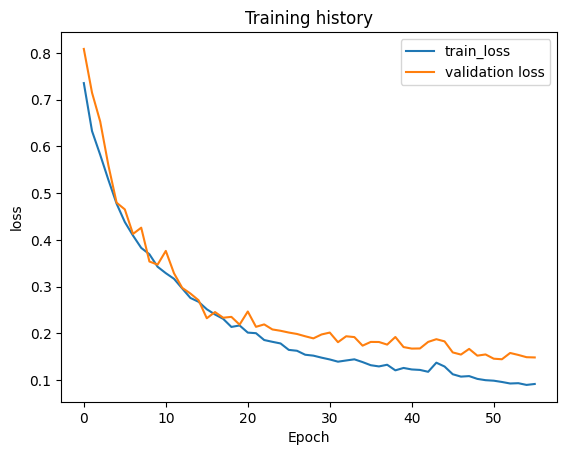

In [ ]:
def plot_loss(history : dict):
  plt.plot(history['train_loss'], label='train_loss')
  plt.plot(history['val_loss'], label='validation loss')

  plt.title('Training history')
  plt.ylabel('loss')
  plt.xlabel('Epoch')
  plt.legend()
plot_loss(history)

# Predictions

In [ ]:
prediction=model(torch.tensor(X_test[56][np.newaxis,...],device=DEVICE)).cpu().detach().numpy()

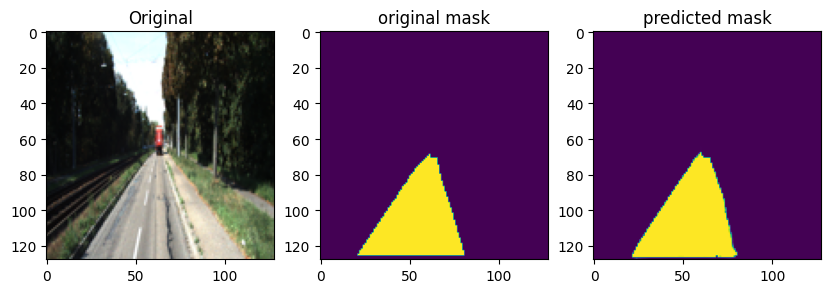

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[56].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[56].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(prediction[0].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

In [ ]:
def get_predicted_masks(model, data_loader, loss_fn, device):
    model = model.eval()

    masks=[]
    losses = []

    with torch.no_grad():
        for test_input, test_mask in data_loader:

            test_mask = test_mask.to(device)
            test_input=test_input.to(device)
            outputs=model(test_input.float())

            masks.append(outputs.cpu().detach().numpy())

            loss = loss_fn(outputs.float(), test_mask.float())
            losses.append(loss.item())

    return np.mean(losses),masks

In [ ]:
loss,masks=get_predicted_masks(model,test_dataloader,loss_fn,DEVICE)
print(loss)

0.08583050966262817


In [ ]:
predicted_masks=np.array(masks[0])
for idx in range(1,len(masks)):
    predicted_masks=np.vstack((predicted_masks, masks[idx]))

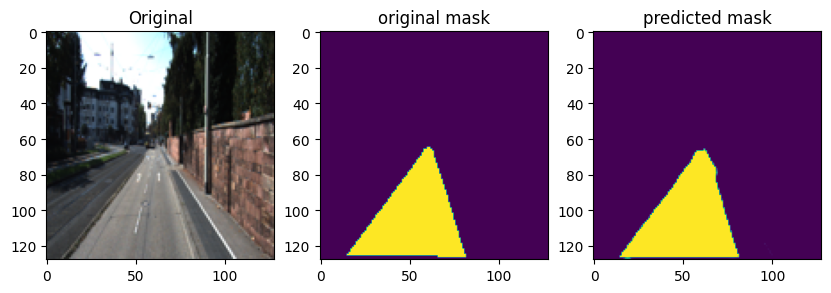

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[2].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[2].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[2].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

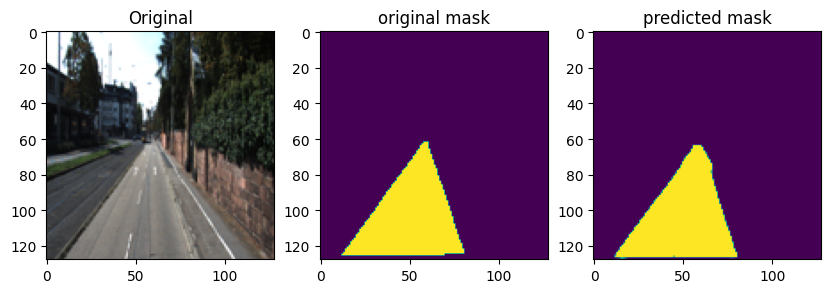

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[1].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[1].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[1].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

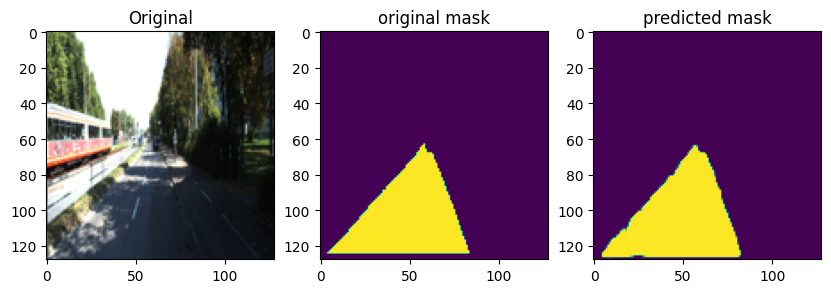

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[14].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[14].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[14].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()

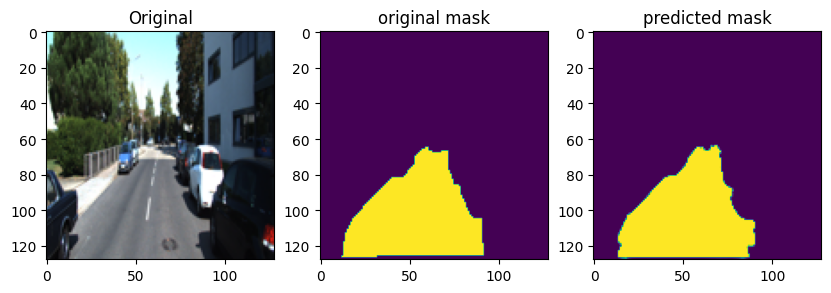

In [ ]:
#test cases
# Show the original and augmented images side by side
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(X_test[4].transpose(1,2,0))
ax[0].set_title("Original")

ax[1].imshow(y_test[4].transpose(1,2,0))
ax[1].set_title("original mask")


ax[2].imshow(predicted_masks[4].transpose(1,2,0))
ax[2].set_title("predicted mask")

plt.show()